# Learning and controlling a room's temperature
### By Farzad Vatandoust
### Email: vatandoustf@gamil.com
### GitHub: https://github.com/FarzadVatandoust

Table of content


# Introduction

The goal of this projects is to exmine different ways to control a temperature of a room with a model predictive controller. This control method  rquires a surrogate model of the plant to predict the plant behavior in a near future which is typically called control horizon. The controller optimize the controls input for the horizon and use the first prediciotn as the actual control input. Later, after aqcuiring the feedback from actual plant the controller shift its horizon forward and does the same process again. The advantages of this method are that the controller adjust the it's input based on the event in the future and the user can apply constraints on the controller inputs during the process. the figure blow represent a detailed schematic of the model predictive control.


![Model Predictive controll](./pic/pic1.png "Text to show on mouseover")

As you may unterstood yourself one of the most crucial part of MPC is the plant surrogate model. There are several methods for create this twin model of the plant from simple method like liniear approximation of the plant to state-of-the-art method like deep learning. The goal of this project is identify the a model for a temperature of the room from temporal data with different method and incorporate them in developing an MPC for controlling the room temperature.

 So, let's start analyzing our data.

## 1: Loading and analyzing the data

First we need to import the required libraries for data analysis and plotting 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv')
values = dataset.values
print(dataset.head())

We can see that our data is consited of seven columns which every rows represent different time. Here the room temperature is the state of our system and the two control variable are supply temperature and airflow current of the heater. The other parameters such heater setpoint and heater mode are not useful for create a surrogate model of our system so we will not use them anymore.

In [ ]:
# drop unwanted data
del dataset['htg_setpoint']
del dataset['htg_mode']
print(dataset.head())

Lets plot our important data to get a better understanding of it.

In [ ]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

The data is represented in three subpplot showing the room-temperature, supply-temperature, and airflow-current. These plots confirm our intuation about a room temperature system since there is direct relationship between the supply_temperature and the airflow_current with the room temperature. However, there is a delay between these parameter and the state of the system which is easliy justifiable.

### Train/Test/Validation split (Global)

here we devide our data into different groups of train, test, and validation and we will use this partitioning for all of our study. Here, since our data is temporal we could not use the conventional random selection. So, we used the method suggestetd in [toardsdatascience.com](https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37).

In [ ]:
train_nu = int(np.floor(0.7 * len(dataset)))
test_nu = int(np.floor(0.15 * len(dataset)))
val_nu = len(dataset) - train_nu - test_nu

# 2: Identifying the system's surrogate model


For identtification method for this project we are two methods. The first one is to use the differential equation model of the room temperature system and approximate its constant by fiiting our model to the data. The second method is using the deep learning techniques like recurrent neural network method for learning the data.

## 2.1: differential equation model

Our differential equation model is as follows,

$C\dot{T}  = K(T_a(t) - T(t))+\dot{m}_s(t) c_a (T_s(t)-T(t))+d(t)$

System output:
- $T(t)$: the room temperature at time $t$

Control parameters:
- $\dot{m}_s$: mass flow rate
- $T_s(t)$: temperature of the supply air

System parameters:
- $K$: the heat transfer coefficient
- $T_a$: the temperature outside the room at time $t$ (Constant)
- $c_a$: the specific heat capacity of air
- $d(t)$:the unknown disturbance into the room at time $t$ (Constant)
- $C$: the heat capacity of the room air,

For this system identification we used different optimization methods and here we give brief summary of their performance. Later, we devlope the succesfull methods and see their results.


- gekko IPOPT : https://apmonitor.com/do/index.php/Main/TCLabA (Too Slow)
- solve_ivp + scipy: 
- julia: 
- CasADi(IPOPT): it is not developed yet


Lets import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
import scipy
import casadi as ca

Train/Test/Validation split

In [ ]:
train_data = dataset[0:train_nu]
test_data = dataset[train_nu:train_nu + test_nu]
test_data = test_data.reset_index()
val_data= dataset[train_nu + test_nu: ]
val_data = val_data.reset_index()

### 2.1.1: solve_ivp + scipy

We define a function for room temperature model

In [ ]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt

Then, we define a function for solving an initial value problem and ploting the difference between the ordinary differential equation model and actual data

In [ ]:
def display_ode(p, model, dataset):


    Ts = np.array(dataset['supply_temp'])
    Ms = np.array(dataset['airflow_current'])
    T0 = dataset['room_temp'][0]
    t = np.arange(0, len(dataset), 1)
    T = np.zeros(len(dataset))
    T[0] = T0
    z0 = T0
    for i in range (1, len(dataset)):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]

    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, T)
    plt.plot(t, dataset['room_temp'][t])
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('T(t)')

    plt.subplot(1,2,2)
    plt.scatter(T/np.max(T), dataset['room_temp'][t]/np.max(dataset['room_temp'][t]))
    lolim = min(np.min(T/np.max(T)),
    np.min(dataset['room_temp'][t]/np.max(dataset['room_temp'][t])))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)

    plt.show()

Later, we create a function for calculation root mean squared error ($RMSE$) and $R^2$ score.

In [ ]:
def RMSE_R2_ode(p, model, dataset):
    Ts = np.array(dataset['supply_temp'])
    Ms = np.array(dataset['airflow_current'])
    T0 = dataset['room_temp'][0]
    t = np.arange(0, len(test_data), 1)
    T = np.zeros(len(test_data))
    T[0] = T0
    z0 = T0
    for i in range (1, len(test_data)):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    actual = np.array(dataset['room_temp'][:len(test_data)])
    predicted = T
    rmse = np.sqrt(sum((actual-predicted)**2)/len(test_data))
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq

Displaying the model performance on testing set before optimization

In [ ]:
p = [100, 70, 2, 10, 3000]
display_ode(p, model, test_data)
rmse, rsq = RMSE_R2_ode(p, model, test_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Displaying the model performance on validation set before optimization

In [ ]:
p = [100, 70, 2, 10, 3000]
display_ode(p, model, val_data)
rmse, rsq = RMSE_R2_ode(p, model, val_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Next, we define an objective function which calculate the root mean squared error between the model and actual data in the training set

In [ ]:
def objective_func(p):
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    actual = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    rmse = np.sqrt(sum((actual-predicted)**2)/train_nu)
    return rmse

Finally we use SLSQP optimization for finding the the constants in our differential equation. This method rquires the lower- and upper- bound for optimization variable. So, we used the feasible range of each of the variables for their bound. The $d(t)$ was defined as air disturbance in the systems and since we are assiginng a constant value to it is not intuitive to give it the wide range.

In [ ]:
initial_condition = ([100, 70, 2, 10, 2000])
bnds = ((0, 300),
        (30, 100),
        (0.001, 10),
        (-100, 100),
        (1000, 10000))
Nfeval = 0
def mycallback(x):
  global Nfeval
  cost = objective_func(x)
  Nfeval += 1
  print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}  {6: 3.6f}'.format(Nfeval, x[0], x[1], x[2], x[3], x[4], cost))

print('{0:4s}        {1:9s}     {2:9s}   {3:9s}   {4:9s}     {5:9s}   {6:9s}'.format('Iter', 'K', 'Ta', 'ca', ' d', 'C', 'Cost')) 
res = scipy.optimize.minimize(objective_func, initial_condition, method='SLSQP', bounds=bnds, tol=1e-6, callback=mycallback)

Save the optimization result

In [ ]:
pd.DataFrame(res.x).to_csv("SLSQP_opt_param.csv", header=None, index=None)

Display the performance of the optimized model on the test set

In [ ]:
p = np.array(pd.read_csv('SLSQP_opt_param.csv', header=None)[0])
display_ode(p, model, test_data)
rmse_test, rsq_test = RMSE_R2_ode(p, model, test_data)
print("RMSE="+str(rmse_test)+", Rsq="+str(rsq_test))

Display the performance of the optimized model on the validation set

In [ ]:
p = np.array(pd.read_csv('SLSQP_opt_param.csv', header=None)[0])
display_ode(p, model, val_data)
rmse_val, rsq_val = RMSE_R2_ode(p, model, val_data)
print("RMSE="+str(rmse_val)+", Rsq="+str(rsq_val))

Let's save the result for future use

In [ ]:
model_compare = pd.DataFrame(np.array([rmse_test, rsq_test, rmse_val, rsq_val]).reshape(1, -1),
                columns = ["rmse_test", "rsq_test", "rmse_val", "rsq_val"],
                index=['ode'])
                
model_compare.to_csv("Model_comparison.csv")

Finally, we compare all the developed method of optimization

In [ ]:
# Julia results
p = np.array([ 188.99, 63.23, 0.051, 1377.81, 9755.25])
j_rmse, j_rsq = RMSE_R2(p, model, test_data)

p = np.array([62.62, 70.30, 0.017, 10.00, 3001.24])
P_rmse, P_rsq = RMSE_R2(p, model, test_data)

print("Julia result :" + "RMSE=" + str(j_rmse) + "," + " R_sq=" + str(j_rsq))
print("Python result :" + "RMSE=" + str(P_rmse) + "," + " R_sq=" + str(P_rsq))

## 2.2: Learn  a Neural Network Model

Neural networks are one of the most prominent techniques in identifying the relation between data. There are several structure for neural network among which the recurrent neural network are the most suitable for temporal data. Long short-term memory network is a special kind of neural network that is developed for handeling large sequences of data since it does not suffer from vanishing gradinet. In this project we developed the LSTM neural network in both TensorFlow and Pytorch to investigate their compatibility of our optimizer in the MPC section.



### 2.2.1: LSTM via tensorflow
In the process of developing this neural network we used several useful resources as follows:
- [Recurrent Neural Networks (RNN) by sentdex](https://www.youtube.com/watch?v=BSpXCRTOLJA&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=7)
- [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
- [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

First, we import the necessary libraries for developing neural network

In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

Then, we load our data to the environment

In [ ]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

In [ ]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

Here, we define a function that changes the shape of our data and makes it compatible for supervised learning

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

We normalize the data and use the function to change our data

In [ ]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

As you can see the data is changed and to $T(k-1)$, $T_s(k-1)$, $M_s(k-1)$, $T(k)$  so it can be used to learn following function:
 
 $T(k) = F(T(k-1), T_s(k-1), M_s(k-1))$


After that we just reshape our data for the prescribed shapes of the LSTM network.

In [ ]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
val_X, val_y = validation[:, :-1], validation[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

Here, we define our neural network model architecture and hyperparameters. Then, we train our model

In [ ]:
...
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
opt = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yscale('log')
plt.show()

Let's save our trained model

In [ ]:
model.save('/content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp')

Here, we define the RMSE_R2 and display functions.

In [ ]:
def RMSE_R2(actual, predicted):
     
    rmse = np.sqrt(sum((actual-predicted)**2)/len(actual))
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq


In [ ]:
def display(actual, predicted):

    t = np.arange(0, len(actual), 1)
    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, predicted)
    plt.plot(t, actual)
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('T(t)')

    plt.subplot(1,2,2)
    plt.scatter(predicted/np.max(predicted), actual/np.max(actual))
    lolim = min(np.min(predicted/np.max(predicted)),
    np.min(actual/np.max(actual)))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)

    plt.show()

Make prediction for testing and validation set.

In [ ]:
# make a prediction
yhat_test = model.predict(test_X)
inv_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat_test = np.concatenate((yhat_test, inv_test_X[:, 1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
# invert scaling for actual
inv_y_test = test_y.reshape((len(test_y), 1))
inv_y_test = np.concatenate((inv_y_test, inv_test_X[:, 1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]

In [ ]:
# make a prediction
yhat_val = model.predict(val_X)
inv_val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
# invert scaling for forecast
inv_yhat_val = np.concatenate((yhat_val, inv_val_X[:, 1:]), axis=1)
inv_yhat_val = scaler.inverse_transform(inv_yhat_val)
inv_yhat_val = inv_yhat_val[:,0]
# invert scaling for actual
inv_y_val = val_y.reshape((len(val_y), 1))
inv_y_val = np.concatenate((inv_y_val, inv_val_X[:, 1:]), axis=1)
inv_y_val = scaler.inverse_transform(inv_y_val)
inv_y_val = inv_y_val[:,0]

test_set analysis

In [ ]:
display(inv_y_test, inv_yhat_test)
rmse_test, rsq_test = RMSE_R2(inv_y_test, inv_yhat_test)
print("RMSE="+str(rmse_test)+", Rsq="+str(rsq_test))

Validation set analysis

In [ ]:
display(inv_y_val, inv_yhat_val)
rmse_val, rsq_val = RMSE_R2(inv_y_val, inv_yhat_val)
print("RMSE="+str(rmse_val)+", Rsq="+str(rsq_val))

Let's save the results

In [ ]:
model_compare = pd.read_csv('Model_comparison.csv', index_col=0)
new_row = pd.DataFrame(np.array([rmse_test, rsq_test, rmse_val, rsq_val]).reshape(1, -1),
                columns = ["rmse_test", "rsq_test", "rmse_val", "rsq_val"], index=['keras'],
                )
if 'keras' in model_compare.index:
    print('start from ODE result')
    
model_compare = model_compare.append(new_row)
model_compare.to_csv("Model_comparison.csv")

### Section 2.2.2: Pytorch

Neural network development with pytorch requires similar steps like tensorflow. 

In the process of developing this neural network we used the instruction in the [cnvrg.io](https://cnvrg.io/pytorch-lstm/) 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

In [ ]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_val, y_val = validation[:, :-1], validation[:, -1]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 
print("Validation Shape", X_val.shape, y_val.shape) 

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [ ]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [ ]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
        # self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        # out = self.relu(out) #relu
        # out = self.fc(out) #Final Output
        return out

In [ ]:
num_epochs = 1000 #100 epochs
learning_rate = 0.001 #0.01 lr

input_size = 3 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [ ]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 20 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [ ]:
def display(actual, predicted):

    t = np.arange(0, len(actual), 1)
    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, predicted)
    plt.plot(t, actual)
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('T(t)')

    plt.subplot(1,2,2)
    plt.scatter(predicted/np.max(predicted), actual/np.max(actual))
    lolim = min(np.min(predicted/np.max(predicted)),
    np.min(actual/np.max(actual)))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)

    plt.show()

In [ ]:
def RMSE_R2(actual, predicted):
     
    rmse = np.sqrt(sum((actual-predicted)**2)/len(actual))
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq

In [ ]:
X_test_tensor = Variable(torch.Tensor(X_test)) #converting to Tensors
#reshaping the dataset
X_test_tensor = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
test_predict = lstm1(X_test_tensor)#forward pass
test_predict = test_predict.data.numpy() #numpy conversion

inv_test_predict = np.concatenate((test_predict, X_test[:, 1:]), axis=1)
inv_test_predict = scaler.inverse_transform(inv_test_predict)
inv_test_predict = inv_test_predict[:,0]

inv_test = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
inv_test = inv_test[:,0]

In [ ]:
X_val_tensor = Variable(torch.Tensor(X_val)) #converting to Tensors
#reshaping the dataset
X_val_tensor = torch.reshape(X_val_tensor, (X_val_tensor.shape[0], 1, X_val_tensor.shape[1]))
val_predict = lstm1(X_val_tensor)#forward pass
val_predict = val_predict.data.numpy() #numpy conversion

inv_val_predict = np.concatenate((val_predict, X_val[:, 1:]), axis=1)
inv_val_predict = scaler.inverse_transform(inv_val_predict)
inv_val_predict = inv_val_predict[:,0]

inv_val = np.concatenate((y_val, X_val[:, 1:]), axis=1)
inv_val = scaler.inverse_transform(inv_val)
inv_val = inv_val[:,0]

In [ ]:
display(inv_test, inv_test_predict)
rmse_test, rsq_test = RMSE_R2(inv_test, inv_test_predict)
print("RMSE="+str(rmse_test)+", Rsq="+str(rsq_test))

In [ ]:
display(inv_val, inv_val_predict)
rmse_val, rsq_val = RMSE_R2(inv_val, inv_val_predict)
print("RMSE="+str(rmse_val)+", Rsq="+str(rsq_val))

In [253]:
model_compare = pd.read_csv('Model_comparison.csv', index_col=0)
new_row = pd.DataFrame(np.array([rmse_test, rsq_test, rmse_val, rsq_val]).reshape(1, -1),
                columns = ["rmse_test", "rsq_test", "rmse_val", "rsq_val"], index=['pytorch'],
                )
if 'pytorch' in model_compare.index:
    print('start from ODE result')
 
model_compare = model_compare.append(new_row)
model_compare.to_csv("Model_comparison.csv")

start from ODE result


C:\Users\FarzadLT1\AppData\Local\Temp\ipykernel_2796\3698103975.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_compare = model_compare.append(new_row)


In [ ]:
torch.save(lstm1.state_dict(), "Pytorch_LSTM.pth")

## 2.3: Models comparison

We compare the RMSE and R2 for both testing and validation set

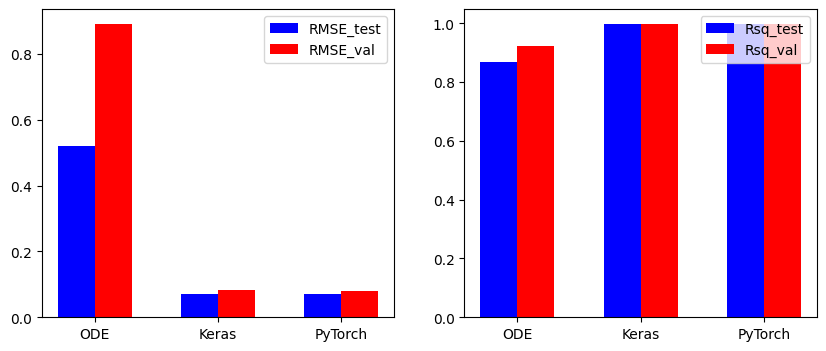

In [243]:
model_compare = pd.read_csv('Model_comparison.csv', index_col=0)
ind = np.arange(3)
# x = ['ODE', 'Keras', 'Pytorch']
bar_width = 0.3 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(ind, model_compare['rmse_test'].to_numpy(),
         color='b', width=bar_width,
         label='RMSE_test')

plt.bar(ind + bar_width, model_compare['rmse_val'].to_numpy(),
         color='r', width=bar_width,
         label='RMSE_val')
plt.legend(loc='best')
plt.xticks(ind + bar_width / 2, ('ODE', 'Keras', 'PyTorch'))

plt.subplot(1, 2, 2)
plt.bar(ind, model_compare['rsq_test'].to_numpy(),
         color='b', width=bar_width,
         label='Rsq_test')

plt.bar(ind + bar_width, model_compare['rsq_val'].to_numpy(),
         color='r', width=bar_width,
         label='Rsq_val')
plt.legend(loc='best')
plt.xticks(ind + bar_width / 2, ('ODE', 'Keras', 'PyTorch'))

plt.show()



# 3: MPC
After identifying the model for our system in the previous section. We are ready to implement the MPC. The objective function and the constraints for our MPC are as follows:

$Objective\:function = ||yt - y|| + c * \sum(a(T_s - 55) + b(\dot{m}_s-400) $

$ Subject\:to: 55<T_s<90,\: 400<\dot{m}_s<1000\:(Soft\:constraints)
$  

$ Subject\:to:|\Delta{T_s}|<8,\: |\Delta{\dot{m}_s}|<65\:(Hard\:constraints)$.

Where $yt$ is the predicted state of our model based on the optimzied control inputs in the prediction horizon. $y$ is the reference state for control. So, the First part of our network calculate the difference between our desired state with the predicted state. The second part of is called activatin cost and it aims to reduce the enerfy spenditure of the controller. 

In the process of developing this section we used numerous resources. Here, we list the most important ones.
- Model Predictive Control by Steve Brunton [ [link](https://www.youtube.com/watch?v=YwodGM2eoy4) ]
- A series of lectures by Mohamed W. Mehrez [ [link](https://www.youtube.com/watch?v=RrnkPrcpyEA) ]
- John Hedengren site [ [link](https://apmonitor.com/do/index.php/Main/TCLabG) ]
- A series of lectures by MathWorks [ [link](https://www.youtube.com/playlist?list=PLn8PRpmsu08ozoeoXgxPSBKLyd4YEHww8) ]
- CasADi documentation [ [link](https://web.casadi.org/docs/) ]
- A great video by APMonitor [ [link](https://www.youtube.com/watch?v=DFqOf5wbQtc) ]

- CasADi blog post [ [link](https://web.casadi.org/blog/tensorflow/) ]
- Introduction of CasADi [ [link](https://www.youtube.com/watch?v=JC6PNjndQ_c&t=61s
) ]

Papers :
- Real-time Neural-MPC: Deep Learning Model Predictive Control for Quadrotors and Agile Robotic Platforms[ [link](https://arxiv.org/abs/2203.07747) ]
- Recurrent Neural Network-Based Model Predictive Control for Continuous Pharmaceutical Manufacturing [ [link](https://www.mdpi.com/2227-7390/6/11/242/htm) ]

## 4.1: Casadi + ODE

In [290]:
# import libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from casadi import *
from casadi.tools import *

#######################################
##########  Parameters  ###############
#######################################

N = 3 # Horizon length
runtime = 50
dt = 1;          # Time step
x0 = 70.0        # Initial temperature
xs = 72.5        # Reference Temperature

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

# Constraints parameters
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0


# Optimization parameters
obj = 0
a = 1
b = 0.01
sigma = 0.00001


#######################################
#######  CasADi optimization   ########
#######################################

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states, controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states, controls],[states_1])


# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# objective function
obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


# define lower and upper bound for constraints
args = {}
upperb = []
lowerb = []
for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)

args['lbg'] = lowerb
args['ubg'] = upperb

#######################################
##########  MPC simulation  ###########
#######################################

# define empty arrays o store simulation data
t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)
cost = []
cost.append(100)
TTs = []
TTs.append(min_Ts)
MMs = []
MMs.append(min_Ms)


# The initial guess for optimization
u0 = []
for i in range(N):
  u0 += [55]
  u0 += [400]


# simulate
args['x0'] = u0

for i in range(1,runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])

  st_next = phi(args['p'][0], sol['x'][0:2])

  # shift to the next time 
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]

  # Use the result of MPC optimization as next
  #  stage optimization initial guess
  args['x0'] = vertcat(sol['x'][2:],sol['x'][:2])
  
  #store the simulation data
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])


      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  66.00us (  2.54us)        26
       nlp_g  |        0 (       0)  82.00us (  3.15us)        26
    nlp_grad  |        0 (       0)   6.00us (  6.00us)         1
  nlp_grad_f  |        0 (       0)  74.00us (  2.96us)        25
   nlp_jac_g  |        0 (       0)  45.00us (  1.80us)        25
       total  |  61.00ms ( 61.00ms)  60.76ms ( 60.76ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  34.00us (  2.12us)        16
       nlp_g  |        0 (       0)  36.00us (  2.25us)        16
    nlp_grad  |        0 (       0)   5.00us (  5.00us)         1
  nlp_grad_f  |        0 (       0)  40.00us (  2.35us)        17
   nlp_jac_g  |        0 (       0)  25.00us (  1.47us)        17
       total  |  43.00ms ( 43.00ms)  43.63ms ( 43.63ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

Display the the optimization result

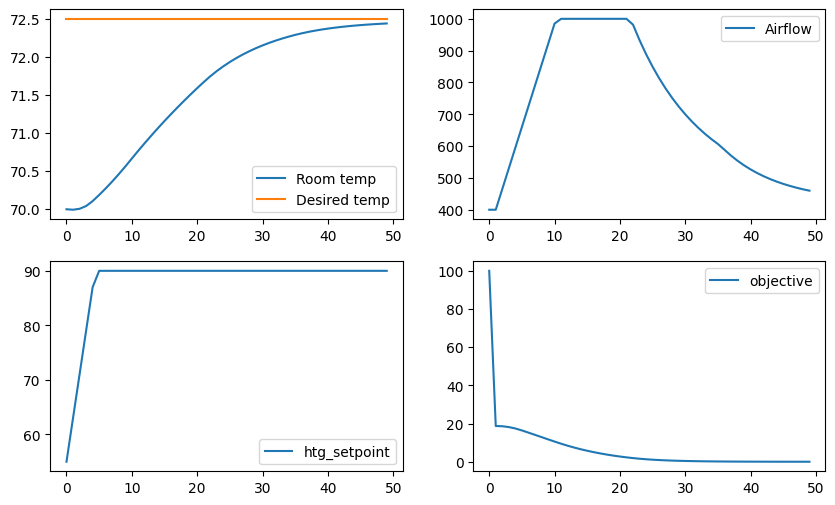

In [279]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx)
plt.plot(t, xxs)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()


## 4.2 CasADi + LSTM (Keras)

### Slow  version

In [ ]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


In [ ]:
LSTM_model = keras.models.load_model("LSTM_room_temp")

In [ ]:
# Callback function for evaluating LSTM

class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    input = np.array([arg[0], arg[1], arg[2]]).astype('float32').reshape(1,-1)
    input_reframed = input.reshape((input.shape[0], 1, input.shape[1]))
    f = LSTM_model(input_reframed)
    return [f.numpy()[0, 0]]

In [ ]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [ ]:
lstm = MyCallback('lstm', {"enable_fd":True})

T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

In [ ]:
runtime = 40
N = 3 # Horizon length
dt = 1; # Time step
obj = 0
a = 1
b =0.000001
sigma = 0.00001
#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0


max_delta_Ms = 65.0
min_delta_Ms = -65.0


# Soft constraints
max_Ts = 90.0
min_Ts = 55.0


max_Ms = 1000.0
min_Ms = 400.0


min_Ts_global = min_Ts
min_Ms_global = min_Ms

# Lets run our simulation ********
x0 = 70.0
xs = 72.5


#Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)




args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


t = np.arange(0, runtime, dt)
xxs = np.full((runtime, 1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(0)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

#************** 
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])


In [ ]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()

## 4.3 CasADi + LSTM (PyTorch)

-https://arxiv.org/pdf/2203.07747.pdf

In [ ]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd

import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

import numpy as np
import time


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [ ]:

loaded_lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, input_size)
loaded_lstm.load_state_dict(torch.load("Pytorch_LSTM.pth"))
loaded_lstm.eval()

In [ ]:
class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    T = arg[0]
    Ts = arg[1]
    Ms = arg[2]
    input = np.array([T, Ts, Ms]).astype('float32').reshape(1,-1)
    input_tensor = Variable(torch.Tensor(input)) 
    input_tensor = torch.reshape(input_tensor, (input_tensor.shape[0], 1, input_tensor.shape[1]))
    output = loaded_lstm(input_tensor)
    output = output.detach().numpy()
    return [output]

In [ ]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [ ]:
lstm = MyCallback('lstm', {"enable_fd":True})
T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

In [254]:

runtime = 40
N = 3 # Horizon length
dt = 1; # Time step
obj = 0
a = 1
b =0.01
sigma = 0.00001
#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0


max_delta_Ms = 65.0
min_delta_Ms = -65.0


# Soft constraints
max_Ts = 90.0
min_Ts = 55.0


max_Ms = 1000.0
min_Ms = 400.0


min_Ts_global = min_Ts
min_Ms_global = min_Ms

# Lets run our simulation ********
x0 = 70.0
xs = 72.5


#Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)




args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


t = np.arange(0, runtime, dt)
xxs = np.full((runtime, 1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(0)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

#************** 
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])



NameError: name 'normaldelta' is not defined

In [ ]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()